Scenario                     | Controller | RMSE (m)   | Energy    
Scn 1: Summer (Calm Sea)     | LQR        | 0.667     | 17.4
                             | Fuzzy-LQI  | 0.667     | 17.4
Scn 2: Winter (Strong Wind)  | LQR        | 15.229     | 918.4
                             | Fuzzy-LQI  | 1.168     | 1294.6


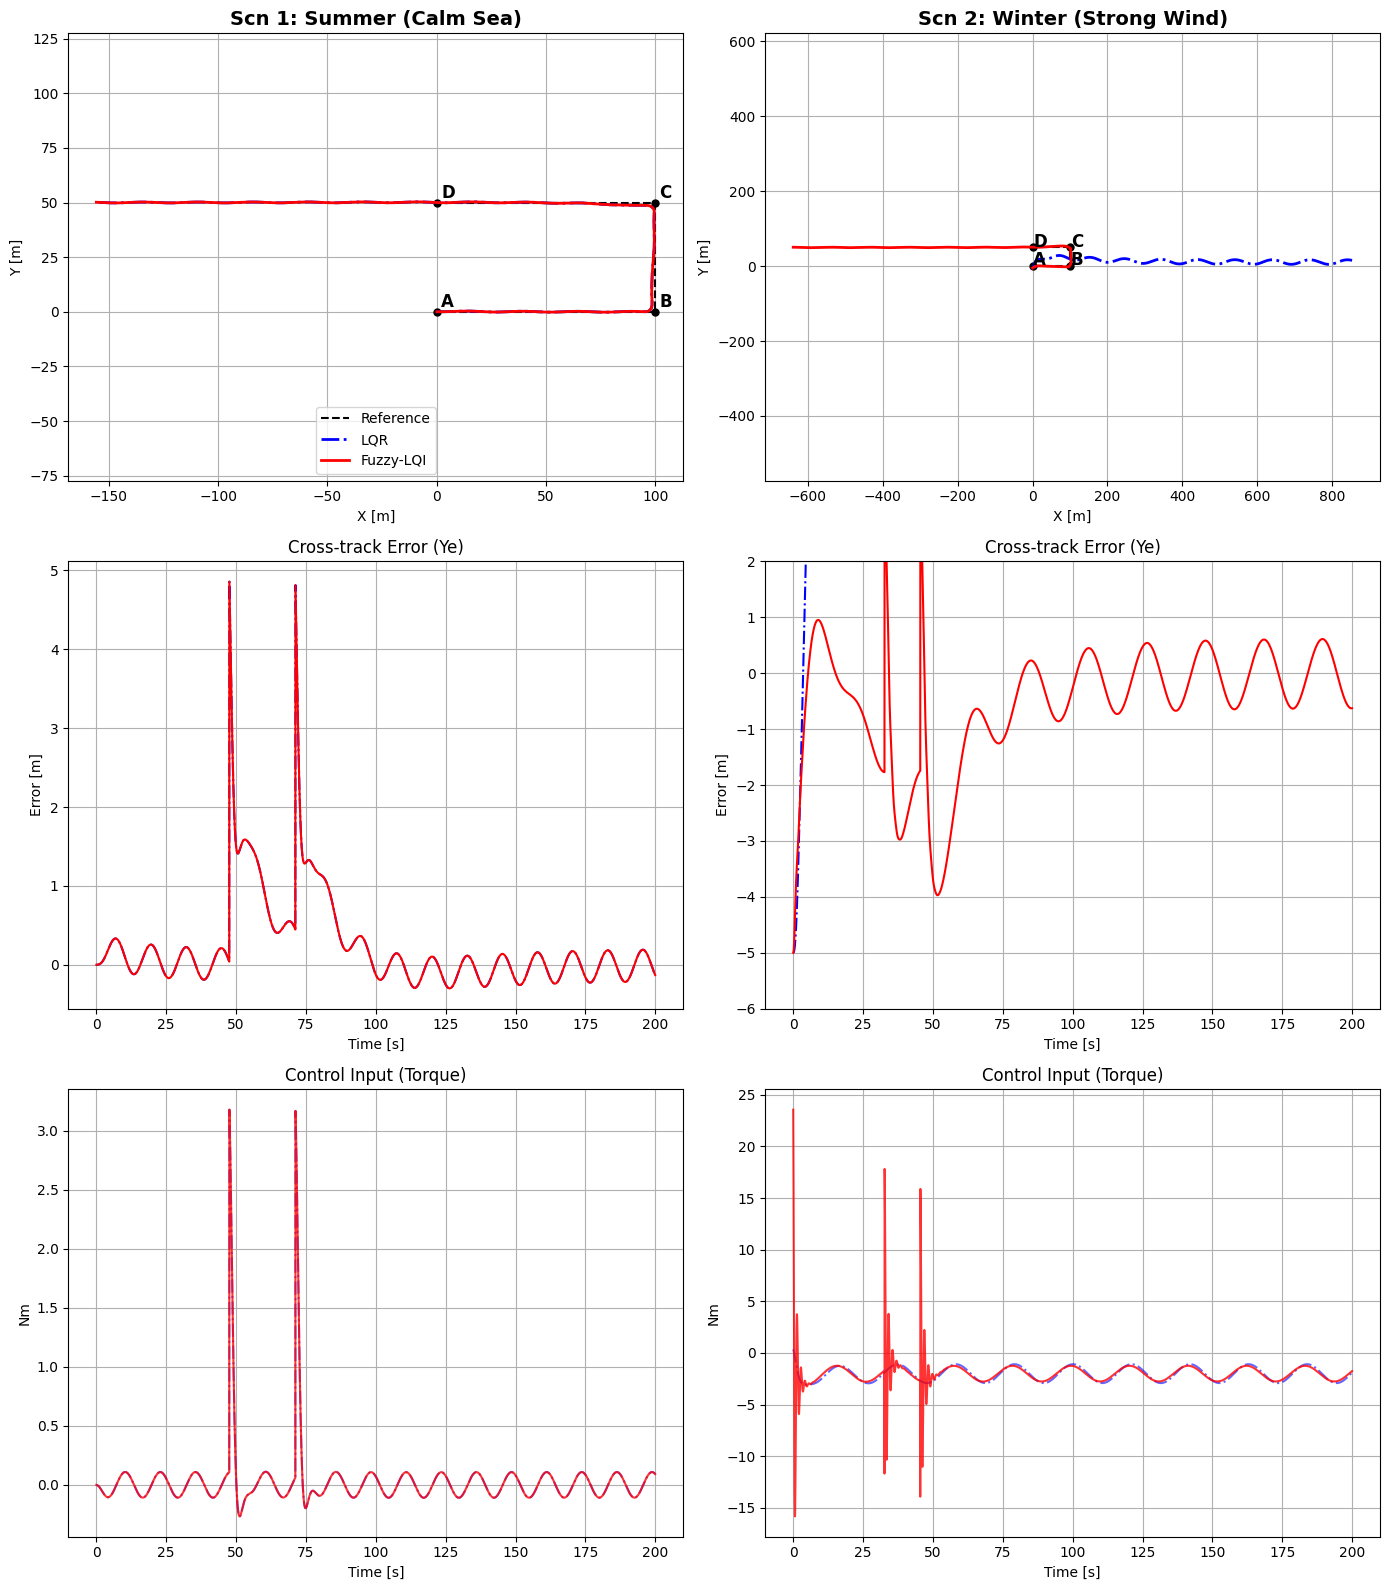

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are

# ============================================================
# 1. CẤU HÌNH TÀU & MÔI TRƯỜNG
# ============================================================
m = 23.8
Iz = 1.76
Yv = 0.88
Nr = 1.90

U_spd = 2.0
dt = 0.05
T_max = 200
time = np.arange(0, T_max, dt)

# Các điểm Waypoint
waypoints = np.array([
    [0.0, 0.0],    # A
    [100.0, 0.0],  # B
    [100.0, 50.0], # C
    [0.0, 50.0]    # D
])
wp_labels = ['A', 'B', 'C', 'D'] # Tên các điểm
R_accept = 5.0

# ============================================================
# 2. MÔ HÌNH NHIỄU (ĐÃ TĂNG CƯỜNG ĐỂ LQR BỊ TRÔI)
# ============================================================
np.random.seed(42)

def calculate_disturbances(t, scenario):
    if scenario == 1:   # Summer: Sóng nhẹ
        Fy = 0.2 * np.cos(0.5 * t)
        Mz = 0.1 * np.sin(0.5 * t)
    else:               # Winter: Gió Bão Mạnh (Tăng Bias lên 4.0N)
        # Bias lớn này sẽ đẩy LQR trôi hẳn ra ngoài
        Fy = 4.0 + 1.5 * np.sin(0.3 * t)
        Mz = 0.5 * Fy # Gió tạo moment xoay
    return Fy, Mz

# ============================================================
# 3. THIẾT KẾ LQR / LQI (ĐIỀU CHỈNH GAIN)
# ============================================================
def compute_gain(q_y, q_int, r_val):
    A = np.zeros((5, 5))
    A[0, 0] = -Yv / m; A[0, 1] = -U_spd
    A[1, 1] = -Nr / Iz; A[2, 1] = 1.0
    A[3, 0] = 1.0; A[3, 2] = U_spd; A[4, 3] = 1.0
    B = np.zeros((5, 1)); B[1, 0] = 1.0 / Iz
    Q = np.diag([0.1, 1.0, 1.0, q_y, q_int])
    R = np.array([[r_val]])
    P = solve_continuous_are(A, B, Q, R)
    return np.linalg.inv(R) @ B.T @ P

# --- Tinh chỉnh Gain để tạo sự khác biệt rõ rệt ---
# LQR: Giảm Q_y, Tăng R -> "Lười" sửa lỗi -> Sẽ bị trôi khi gió lớn
K_LQR = compute_gain(q_y=1.0,  q_int=0.0, r_val=200.0)

# Fuzzy-LQI: Gain tích phân mạnh -> Kéo tàu về đường dẫn bất chấp gió
K_LQI = compute_gain(q_y=80.0, q_int=5.0, r_val=20.0)

# ============================================================
# 4. SUPERVISOR
# ============================================================
def select_controller(scenario):
    if scenario == 1: return K_LQR, False
    else: return K_LQI, True

# ============================================================
# 5. MÔ PHỎNG
# ============================================================
def run_simulation(scenario, mode):
    # Kịch bản 2: LQR xuất phát lệch để thấy rõ không về được
    y_init = 0.0 if scenario == 1 else -5.0

    x, y, psi = 0.0, y_init, 0.0
    u, v, r = U_spd, 0.0, 0.0
    wp_idx = 0; int_ye = 0.0; tau_prev = 0.0
    pos_hist, ye_hist, tau_hist = [], [], []
    energy_sum = 0.0

    for t in time:
        wp_start = waypoints[wp_idx]
        wp_end   = waypoints[wp_idx + 1]

        # Chuyển WP
        if np.linalg.norm([x - wp_end[0], y - wp_end[1]]) < R_accept and wp_idx < len(waypoints) - 2:
            wp_idx += 1
            int_ye = 0.0 # Reset tích phân khi qua điểm mới

        # Tính toán lỗi
        path_angle = np.arctan2(wp_end[1] - wp_start[1], wp_end[0] - wp_start[0])
        ye = -(x - wp_start[0]) * np.sin(path_angle) + (y - wp_start[1]) * np.cos(path_angle)
        psi_err = (psi - path_angle + np.pi) % (2*np.pi) - np.pi

        # Chọn điều khiển
        if mode == 'LQR':
            K = K_LQR; use_int = False
        else:
            K, use_int = select_controller(scenario)

        # Xử lý tích phân
        if use_int and abs(ye) < 5.0: int_ye += ye * dt
        else: int_ye = 0.0

        x_fb = np.array([v, r, psi_err, ye, int_ye]).reshape(5, 1)
        tau = float((-K @ x_fb)[0, 0])
        tau = np.clip(tau, -50, 50)

        energy_sum += (tau**2 + 0.1*(tau - tau_prev)**2) * dt
        tau_prev = tau

        # Động lực học
        Fy, Mz = calculate_disturbances(t, scenario)
        v_dot = (-Yv*v - u*r + Fy) / m
        r_dot = (tau - Nr*r + Mz) / Iz
        v += v_dot * dt; r += r_dot * dt; psi += r * dt
        x += (u*np.cos(psi) - v*np.sin(psi)) * dt
        y += (u*np.sin(psi) + v*np.cos(psi)) * dt

        pos_hist.append([x, y]); ye_hist.append(ye); tau_hist.append(tau)

    rmse = np.sqrt(np.mean(np.array(ye_hist)[100:]**2))
    return np.array(pos_hist), np.array(ye_hist), np.array(tau_hist), rmse, energy_sum

# ============================================================
# 6. VẼ ĐỒ THỊ (CÓ NHÃN ĐIỂM A, B, C, D)
# ============================================================
scenarios = [(1, "Scn 1: Summer (Calm Sea)"), (2, "Scn 2: Winter (Strong Wind)")]
fig, axs = plt.subplots(3, 2, figsize=(14, 16))

print(f"{'Scenario':<28} | {'Controller':<10} | {'RMSE (m)':<10} | {'Energy':<10}")
print("=" * 70)

for i, (scn, title) in enumerate(scenarios):
    p_lqr, y_lqr, u_lqr, rmse_lqr, e_lqr = run_simulation(scn, 'LQR')
    p_fuz, y_fuz, u_fuz, rmse_fuz, e_fuz = run_simulation(scn, 'Fuzzy')

    print(f"{title:<28} | LQR        | {rmse_lqr:.3f}     | {e_lqr:.1f}")
    print(f"{'':<28} | Fuzzy-LQI  | {rmse_fuz:.3f}     | {e_fuz:.1f}")

    # --- PLOT 1: QUỸ ĐẠO XY ---
    ax1 = axs[0, i]
    # Vẽ đường tham chiếu
    ax1.plot(waypoints[:,0], waypoints[:,1], 'k--', linewidth=1.5, label='Reference')

    # Hiển thị tên các điểm A, B, C, D
    for j, (wx, wy) in enumerate(waypoints):
        ax1.text(wx + 2, wy + 2, wp_labels[j], fontsize=12, fontweight='bold', color='black')
        ax1.plot(wx, wy, 'ko', markersize=5) # Chấm đen tại điểm

    ax1.plot(p_lqr[:,0], p_lqr[:,1], 'b-.', linewidth=2, label='LQR')
    ax1.plot(p_fuz[:,0], p_fuz[:,1], 'r-', linewidth=2, label='Fuzzy-LQI')

    ax1.set_title(title, fontsize=14, fontweight='bold')
    ax1.set_xlabel("X [m]"); ax1.set_ylabel("Y [m]")
    ax1.axis('equal'); ax1.grid(True)
    if i == 0: ax1.legend(loc='lower center')

    # --- PLOT 2: SAI SỐ (Ye) ---
    ax2 = axs[1, i]
    ax2.plot(time, y_lqr, 'b-.', label='LQR')
    ax2.plot(time, y_fuz, 'r-', label='Fuzzy-LQI')
    ax2.set_title("Cross-track Error (Ye)", fontsize=12)
    ax2.set_xlabel("Time [s]"); ax2.set_ylabel("Error [m]")
    ax2.grid(True)
    # Kịch bản 2 set range rộng hơn để thấy LQR bị trôi
    if scn == 2: ax2.set_ylim(-6, 2)

    # --- PLOT 3: TÍN HIỆU ĐIỀU KHIỂN ---
    ax3 = axs[2, i]
    ax3.plot(time, u_lqr, 'b-.', alpha=0.6)
    ax3.plot(time, u_fuz, 'r-', alpha=0.8)
    ax3.set_title("Control Input (Torque)", fontsize=12)
    ax3.set_xlabel("Time [s]"); ax3.set_ylabel("Nm")
    ax3.grid(True)

plt.tight_layout()
plt.show()